In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from networkx import grid_graph
import scipy as sc

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix, to_undirected



In [12]:
from scipy.stats import linregress


def smooth_sobolev_function(L, r, alpha, M):  
    n = L.shape[0]
    eigvalues, eigvectors = sc.linalg.eigh(L.astype(float).toarray())
    #x = np.array([np.log(i/900) for i in np.arange(100, 700)])
    #y = np.log(eigvalues)[100:700]
    #slope, intercept, r_value, p_value, std_err = linregress(x, y)
    #### generate coefficients:
    ###determine growth
    #r = slope
    a_i = np.random.uniform(low=-1, high=1, size=L.shape[0])
    a_i = M * a_i/np.linalg.norm(a_i)
    D = np.diag(1/(1. + n**(2.0/r) * eigvalues)**(alpha/2))
    c_j = D @ a_i
    return(eigvectors @ c_j, eigvectors)

In [3]:
11//3

3

In [13]:
criterion = torch.nn.MSELoss()


class GCN(torch.nn.Module):
    def __init__(self, input_dim, nb_convolutions=1, output_dim=1):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(input_dim, output_dim)
        #self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        #x = x.relu()
        #x = F.dropout(x, p=0.5, training=self.training)
        #x = self.conv2(x, edge_index)
        return x
        
    def train_data(self, data, train_mask):
          optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
          self.train()
          optimizer.zero_grad()  # Clear gradients.
          out = self.forward(data.x, data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          return loss

    def test_data(self, data, f, scale):
          new_Y = np.random.normal(f, scale=scale)
          self.eval()
          pred = self.forward(data.x, data.edge_index)
          test_mse = criterion(pred, torch.from_numpy(new_Y).float())  # Check against ground-truth labels.
          return test_mse, pred


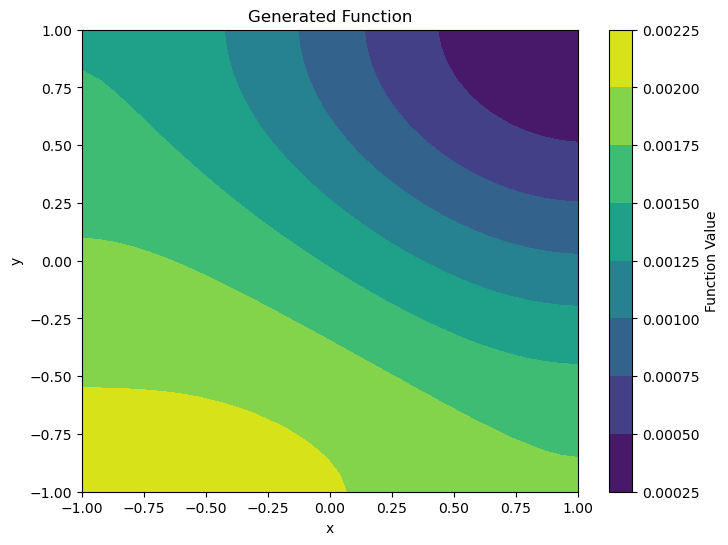

In [19]:
# Define the grid dimension
import pandas as pd
k = 30
# Create the grid graph
G = nx.grid_graph(dim=[k, k])
# Create the meshgrid for the coordinates
x = np.linspace(-1, 1, k)
y = np.linspace(-1, 1, k)
x, y = np.meshgrid(x, y)
# Reshape and combine the coordinates
X_pos = np.hstack([x.reshape([-1, 1]), y.reshape([-1, 1])])
# Create the position dictionary
pos = {(i % k, i // k): [X_pos[i, 0], X_pos[i, 1]] for i in np.arange(X_pos.shape[0])}
n = nx.number_of_nodes(G)
A = nx.adjacency_matrix(G)
A = A.todense() + np.eye(n)
D = np.diag(1./ np.sum(A, 1)**0.5)
A_tilde = D @ A @ D
#edge_index, edge_weights = from_scipy_sparse_matrix(A)
#edge_index, edge_weights = to_undirected(edge_index, edge_weights)

L = nx.laplacian_matrix(G)

Y, _ = smooth_sobolev_function(L, r=4, alpha=10, M=1)
values = Y # Extract values based on node order
x = np.linspace(-1, 1, k)
y = np.linspace(-1, 1, k)
x, y = np.meshgrid(x, y)


# Plot the function
plt.figure(figsize=(8, 6))
plt.contourf(x, y, values.reshape(x.shape), cmap='viridis')
plt.colorbar(label='Function Value')
plt.title('Generated Function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
# norm = plt.Normalize(vmin=min(values), vmax=max(values))
# cmap = plt.cm.viridis  # You can change the colormap here
# colors = [cmap(norm(value)) for value in values]
# nx.draw_kamada_kawai(G, node_color=colors, with_labels=False)
# plt.show()


In [27]:
# Define the grid dimension
import pandas as pd
k = 30
# Create the grid graph
G = nx.grid_graph(dim=[k, k])
# Create the meshgrid for the coordinates
x = np.linspace(-1, 1, k)
y = np.linspace(-1, 1, k)
x, y = np.meshgrid(x, y)
# Reshape and combine the coordinates
X_pos = np.hstack([x.reshape([-1, 1]), y.reshape([-1, 1])])
# Create the position dictionary
pos = {(i % k, i // k): [X_pos[i, 0], X_pos[i, 1]] for i in np.arange(X_pos.shape[0])}
n = nx.number_of_nodes(G)
A = nx.adjacency_matrix(G)
A = A.todense() + np.eye(n)
D = np.diag(1./ np.sum(A, 1)**0.5)
S = D @ A @ D

D2 = np.diag(1./ np.sum(A, 1))
T = D2 @ A
#edge_index, edge_weights = from_scipy_sparse_matrix(A)
#edge_index, edge_weights = to_undirected(edge_index, edge_weights)

L = nx.laplacian_matrix(G)

nb_exp = 10
results = np.zeros((nb_exp * 8 *  6 * 10, 27))
it = 0
S_k = np.eye(n)
T_k = np.eye(n)
for k in np.arange(1, 10):
    S_k = S @ S_k
    T_k = T @ T_k
    for scale in [0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 10]:
        for M in [10]:
            for alpha in [0.01, 0.1, 0.25, 0.5, 0.75, 1]:
                print([k, scale, M, alpha])
                for exp in np.arange(nb_exp):
                    ###
                    f, X =  smooth_sobolev_function(L, r=4, alpha=alpha, M=M) 
                    Y = np.random.normal(f, scale=scale)
                    Y_pred = S_k @ Y
                    ### Fit a GNN to predict what Y is:
                    #data = Data(x=torch.from_numpy(X).float(),
                    #            y = torch.from_numpy(Y).float(),
                    #            edge_index=edge_index,
                    #            edge_weight=edge_weights)
                    #model = GCN(input_dim= X.shape[1], output_dim=1)
                    #data.train_mask = np.random.binomial(n=1, p=0.75, size=n)
                    #data.test_mask = 1-data.train_mask
                    #train_mask  = np.ones((n,))
                    
                    #for epoch in range(1, 101):
                    #    loss = model.train_data(data, train_mask)
                        #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            
                    #pred = model(data.x, data.edge_index)
                    train_acc = np.mean(np.square(Y_pred - Y)) 
                    res_temp = [exp, 0, k,  scale, M, alpha, float(train_acc)]
                    for u in range(20):
                        new_Y = np.random.normal(f, scale=scale)
                        test_mse = (np.square(Y_pred - new_Y)).mean()
                        res_temp += [float(test_mse)]
                    results[it, :] = res_temp
                    pd.DataFrame(results).to_csv("~/Downloads/new_res_gnn.csv")
                    it += 1
                    
                    Y_pred2 = T_k @ Y
                    ### Fit a GNN to predict what Y is:
                    #data = Data(x=torch.from_numpy(X).float(),
                    #            y = torch.from_numpy(Y).float(),
                    #            edge_index=edge_index,
                    #            edge_weight=edge_weights)
                    #model = GCN(input_dim= X.shape[1], output_dim=1)
                    #data.train_mask = np.random.binomial(n=1, p=0.75, size=n)
                    #data.test_mask = 1-data.train_mask
                    #train_mask  = np.ones((n,))
                    
                    #for epoch in range(1, 101):
                    #    loss = model.train_data(data, train_mask)
                        #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            
                    #pred = model(data.x, data.edge_index)
                    train_acc = np.mean(np.square(Y_pred2 - Y)) 
                    res_temp = [exp, 1,  k,  scale, M, alpha, float(train_acc)]
                    for u in range(20):
                        new_Y = np.random.normal(f, scale=scale)
                        test_mse = (np.square(Y_pred2 - new_Y)).mean()
                        res_temp += [float(test_mse)]
                    results[it, :] = res_temp
                    pd.DataFrame(results).to_csv("~/Downloads/new_res_gnn.csv")
                    it += 1
                    #print(it)

                
    
        


[1, 0.01, 10, 0.01]
[1, 0.01, 10, 0.1]
[1, 0.01, 10, 0.25]
[1, 0.01, 10, 0.5]
[1, 0.01, 10, 0.75]
[1, 0.01, 10, 1]
[1, 0.1, 10, 0.01]
[1, 0.1, 10, 0.1]
[1, 0.1, 10, 0.25]
[1, 0.1, 10, 0.5]
[1, 0.1, 10, 0.75]
[1, 0.1, 10, 1]
[1, 0.25, 10, 0.01]
[1, 0.25, 10, 0.1]
[1, 0.25, 10, 0.25]
[1, 0.25, 10, 0.5]
[1, 0.25, 10, 0.75]
[1, 0.25, 10, 1]
[1, 0.5, 10, 0.01]
[1, 0.5, 10, 0.1]
[1, 0.5, 10, 0.25]
[1, 0.5, 10, 0.5]
[1, 0.5, 10, 0.75]
[1, 0.5, 10, 1]
[1, 0.75, 10, 0.01]
[1, 0.75, 10, 0.1]
[1, 0.75, 10, 0.25]
[1, 0.75, 10, 0.5]
[1, 0.75, 10, 0.75]
[1, 0.75, 10, 1]
[1, 1.0, 10, 0.01]
[1, 1.0, 10, 0.1]
[1, 1.0, 10, 0.25]
[1, 1.0, 10, 0.5]
[1, 1.0, 10, 0.75]
[1, 1.0, 10, 1]
[1, 2.0, 10, 0.01]
[1, 2.0, 10, 0.1]
[1, 2.0, 10, 0.25]
[1, 2.0, 10, 0.5]
[1, 2.0, 10, 0.75]
[1, 2.0, 10, 1]
[1, 10, 10, 0.01]
[1, 10, 10, 0.1]
[1, 10, 10, 0.25]
[1, 10, 10, 0.5]
[1, 10, 10, 0.75]
[1, 10, 10, 1]
[2, 0.01, 10, 0.01]
[2, 0.01, 10, 0.1]
[2, 0.01, 10, 0.25]
[2, 0.01, 10, 0.5]
[2, 0.01, 10, 0.75]
[2, 0.01, 10, 1]
[

In [24]:
res_temp

[0,
 'S',
 0,
 0.01,
 10,
 0.01,
 0.08665724304385482,
 0.08698228560095822,
 0.08652767750762509,
 0.08690802640518233,
 0.08646292636295404,
 0.08649808724017287,
 0.08682035901876957,
 0.08671164874782598,
 0.08682655138957188,
 0.08665902906843251,
 0.08665737608594785,
 0.08694177250911028,
 0.08664450467508979,
 0.08657111134603868,
 0.08690910894506237,
 0.08636996394717913,
 0.08666055649630389,
 0.0866385751741625,
 0.0866416751857838,
 0.08671708583813086,
 0.08615082587433787]

In [87]:
np.square(Y_pred - new_Y).mean()

0.00018811135736101673